In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from gym_anytrading.envs import StocksEnv

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

import quantstats as qs

In [46]:
ticker_symbol = "GME" # SP500
start_date = datetime(2020, 1, 1)
end_date = datetime.now()  # Adjust the end date as per the current date
data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02 00:00:00-05:00,1.5350,1.6175,1.5175,1.5775,1.5775,17814400
2020-01-03 00:00:00-05:00,1.5525,1.5625,1.4600,1.4700,1.4700,14175600
2020-01-06 00:00:00-05:00,1.4500,1.4775,1.4000,1.4625,1.4625,13579200
2020-01-07 00:00:00-05:00,1.4425,1.4575,1.3600,1.3800,1.3800,20912000
2020-01-08 00:00:00-05:00,1.3725,1.4625,1.3525,1.4300,1.4300,22517600


In [55]:
data['return'] = np.log(data['Close'] / data['Close'].shift(1))
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Close'] - data['Close'].rolling(50).mean()).shift(1)

lags = 3

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['Close'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols], data['Close'], rcond=None)[0]
data['Prediction'] = np.dot(data[cols], reg)

data.tail()

,Open,High,Low,Close,Adj Close,Volume,return,momentum,volatility,distance,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,Prediction
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12 00:00:00-04:00,25.76,26.889999,25.420000,26.049999,26.049999,16132100,0.018598,0.009613,0.065974,1.265400,...,24.969999,24.600000,24.450001,24.180000,24.370001,23.980000,23.330000,24.690001,25.090000,25.334524
2024-07-15 00:00:00-04:00,25.98,27.200001,25.650000,27.000000,27.000000,17136400,0.035819,0.014898,0.052346,1.446199,...,25.570000,24.969999,24.600000,24.450001,24.180000,24.370001,23.980000,23.330000,24.690001,25.838058
2024-07-16 00:00:00-04:00,27.75,28.830000,27.370001,28.540001,28.540001,25594500,0.055470,0.019841,0.042947,2.074400,...,26.049999,25.570000,24.969999,24.600000,24.450001,24.180000,24.370001,23.980000,23.330000,26.702282
2024-07-17 00:00:00-04:00,28.40,29.790001,27.240000,27.980000,27.980000,23680300,-0.019817,0.029712,0.044836,3.298801,...,27.000000,26.049999,25.570000,24.969999,24.600000,24.450001,24.180000,24.370001,23.980000,28.150725
2024-07-18 00:00:00-04:00,27.98,28.382000,26.350000,26.488001,26.488001,10240054,-0.054798,0.022763,0.033515,2.508600,...,28.540001,27.000000,26.049999,25.570000,24.969999,24.600000,24.450001,24.180000,24.370001,27.954185


In [56]:
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open','High','Low','Volume','return','momentum','volatility','distance','Prediction']].to_numpy()[start:end]
    
    return prices, signal_features

In [57]:
class CustEnv(StocksEnv):
    _process_data = signals

window_size = 5
start_index = window_size
end_train_index = round(len(data)*0.80)
end_val_index = len(data)

env2 = CustEnv(df=data, window_size=window_size, frame_bound=(start_index, end_train_index))

In [63]:
# Learn and train setup
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

policy_kwargs = dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
# Multilayer perceptron (deep neural network w LSTM layer to learn w context)
actor_critic = A2C('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1) 
actor_critic.learn(total_timesteps=100000)

# Final explained variance 0.617 and value_loss value_loss

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 2291     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.737   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.44    |
|    value_loss         | 5.61     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2368     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0.0167   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 38       |
|    value_loss      

In [64]:
env = CustEnv(df=data, window_size=window_size, frame_bound=(end_train_index, end_val_index))

env.signal_features 
env.prices 
env.action_space # Only long and short position

Discrete(2)

In [65]:
observation, info = env.reset()

while True:
    action, _states = actor_critic.predict(observation)

    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

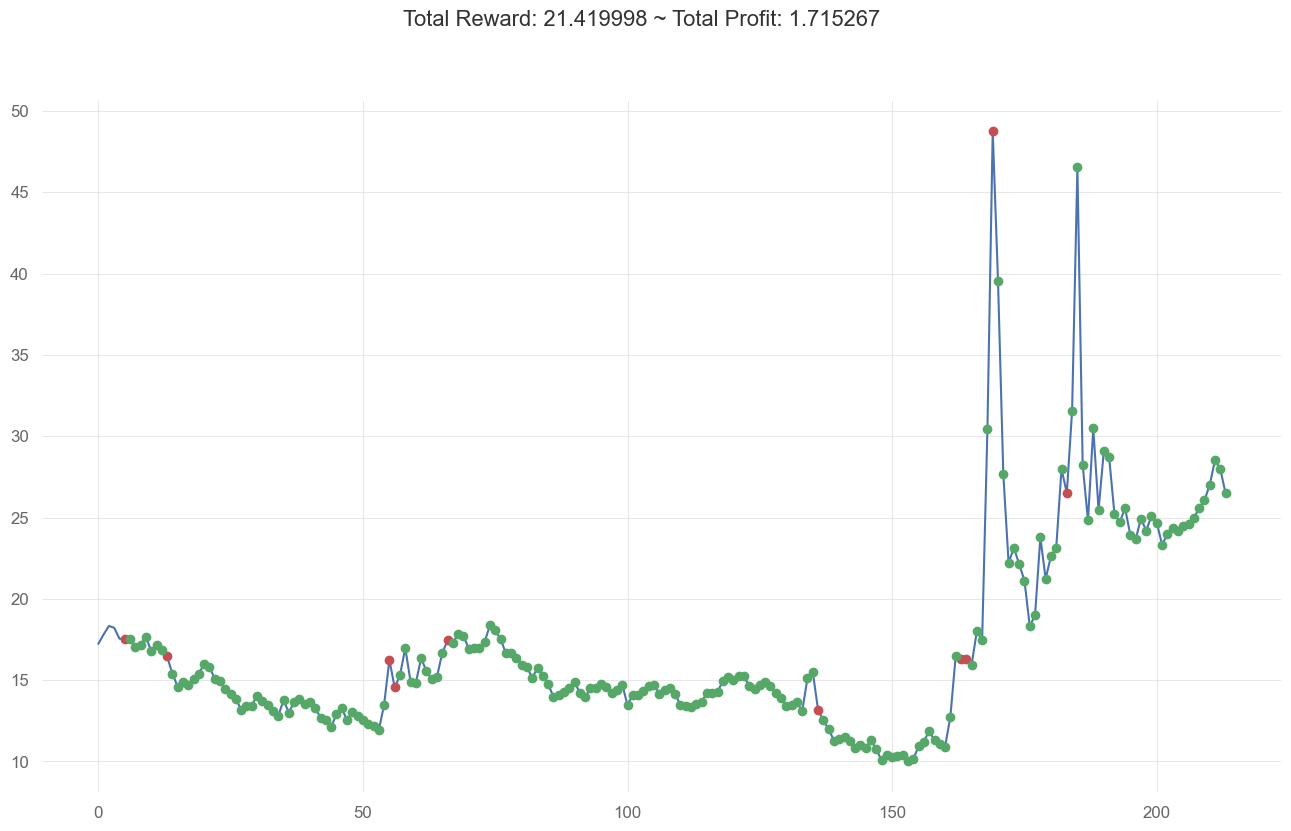

In [61]:
plt.figure(figsize=(16,9))
env.render_all()
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-09-21
End Period                 2024-07-18
Risk-Free Rate             0.0%
Time in Market             4.0%

Cumulative Return          146.32%
CAGR﹪                     112.7%

Sharpe                     1.01
Prob. Sharpe Ratio         94.62%
Smart Sharpe               1.01
Sortino                    8.34
Smart Sortino              8.31
Sortino/√2                 5.9
Smart Sortino/√2           5.87
Omega                      5.12

Max Drawdown               -22.03%
Longest DD Days            218
Volatility (ann.)          226.47%
Calmar                     5.12
Skew                       13.67
Kurtosis                   192.93

Expected Daily %           0.44%
Expected Monthly %         8.54%
Expected Yearly %          56.95%
Kelly Criterion            34.49%
Risk of Ruin               0.0%
Daily Value-at-Risk        -22.56%
Expected Shortfall (cVaR)  -22.56%

Max Consecutive Wins

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-06-04,2024-07-18,2024-07-18,45,-22.029940,-5.660192
2,2023-09-29,2024-03-27,2024-05-03,218,-18.383194,-7.454785


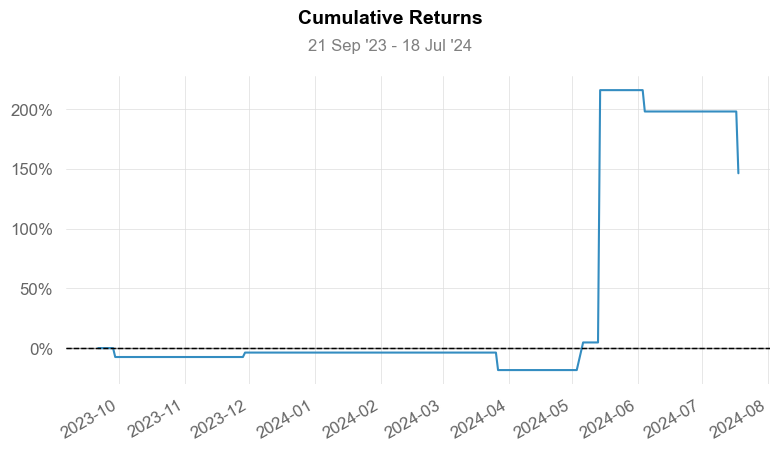

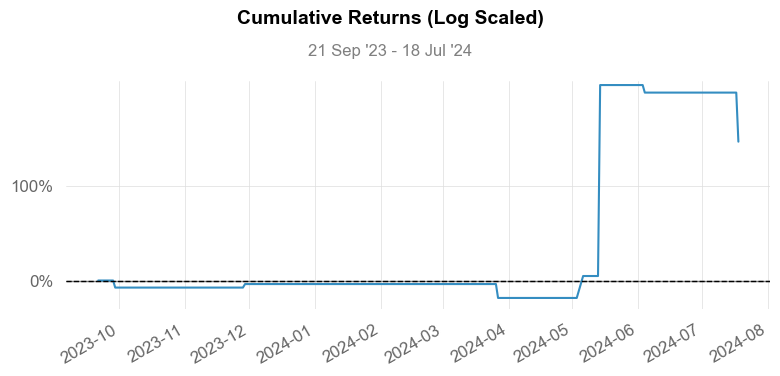

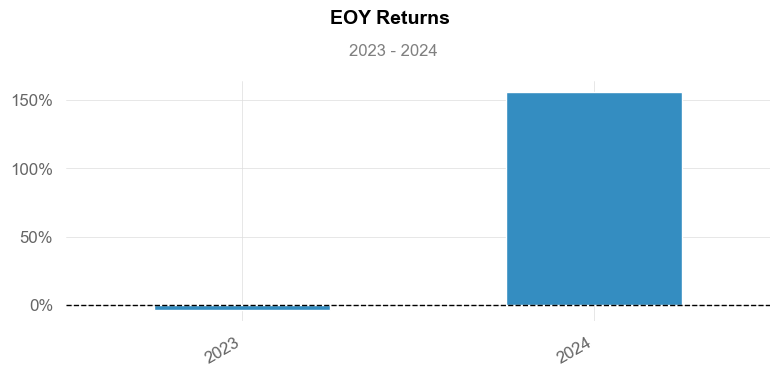

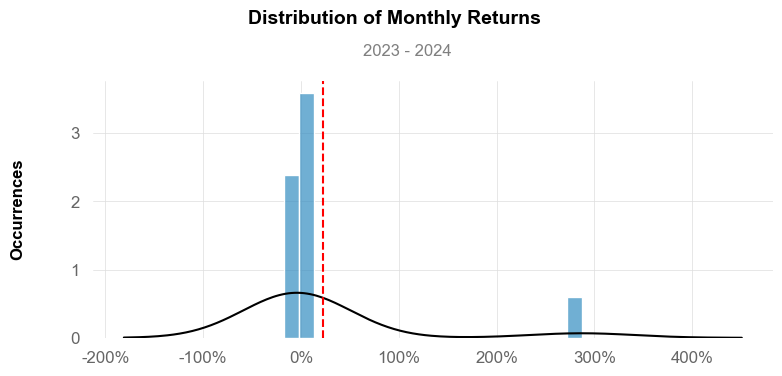

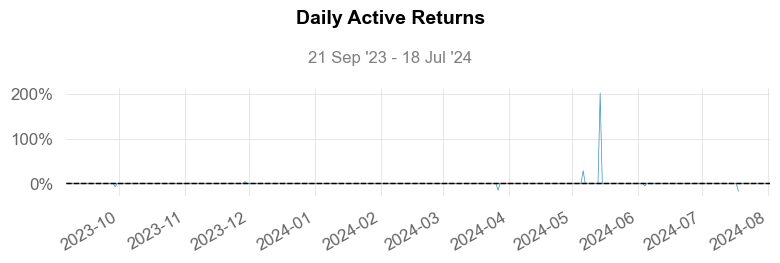

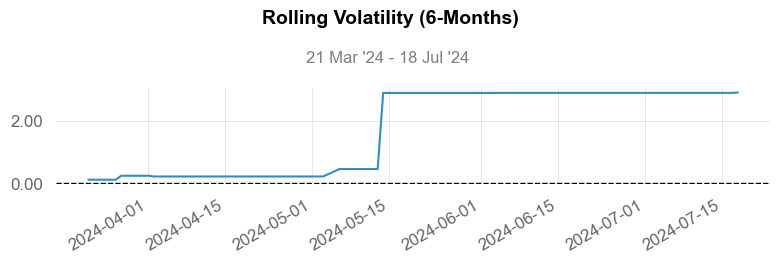

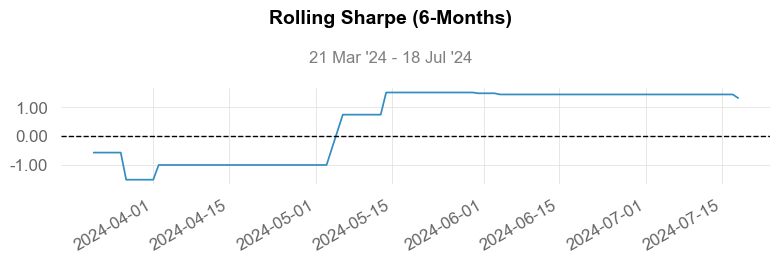

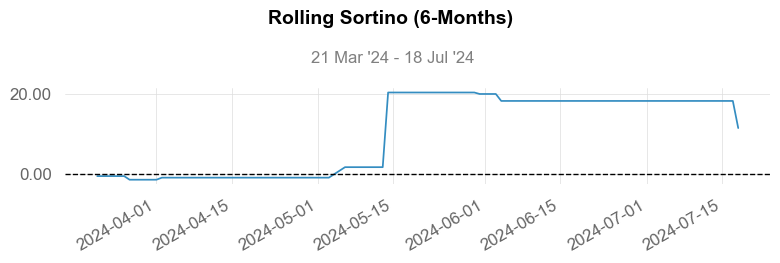

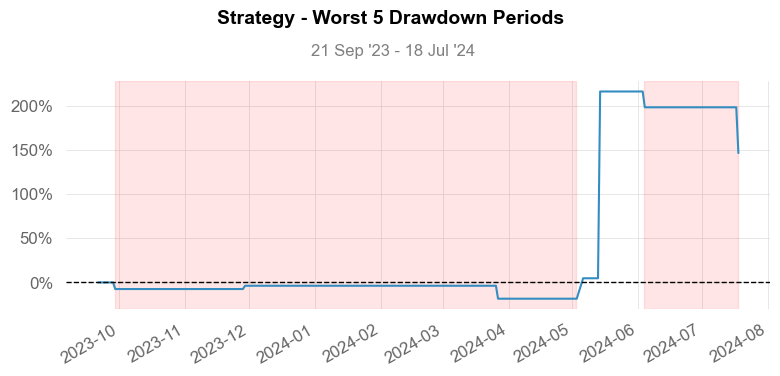

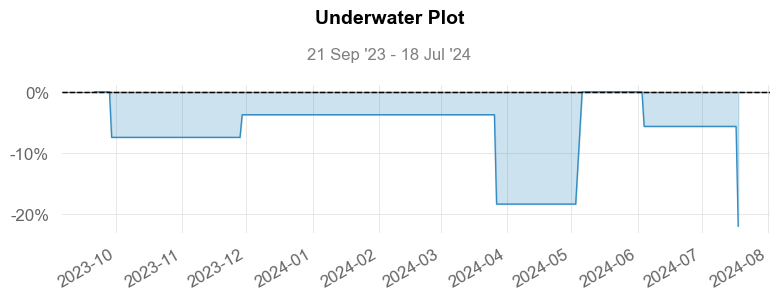

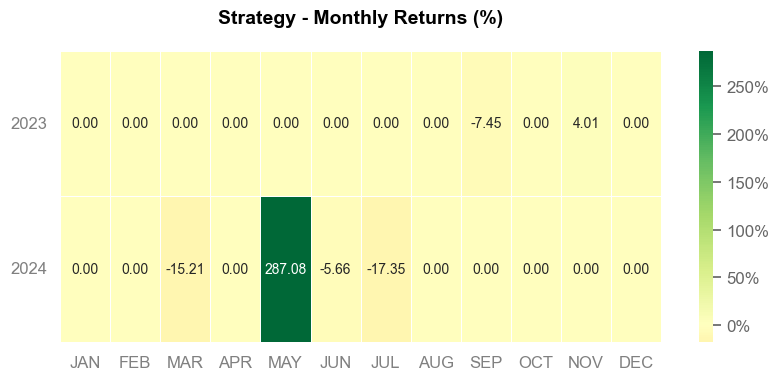

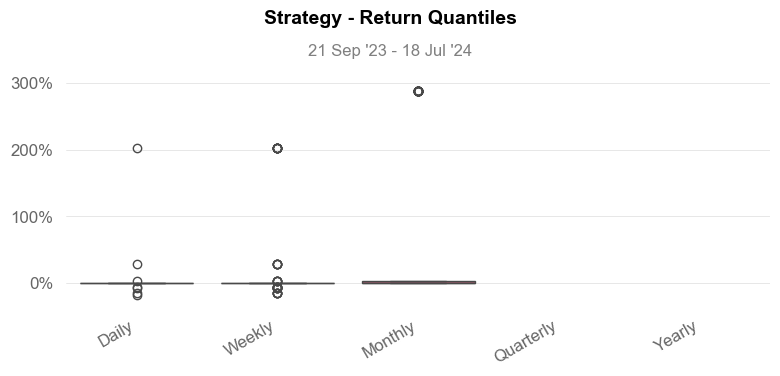

In [66]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[end_train_index+1:end_val_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)